<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc

import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
from jax_ib.base import grids
from jax_ib.base import boundaries
from jax_ib.base import advection,finite_differences
from jax_ib.base import IBM_Force,convolution_functions,particle_motion


<font size="5"> Flow Problem Setup <font size="5">

In [36]:
#-- Flow conditions
density = 1.0
viscosity = 0.05
dt=5e-4
inner_steps = 1000#1800#20#450#1500#1300
outer_steps = 10#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)


#-- CFD Boundary condition parameters
freq=[0.]*4
A=[0.]*4
B=[0.]*4
C=[0.]*4
D=[0.]*4

domain = ((0,15.),(0,15.0))
size=(600,600)
grid = grids.Grid(size, domain=domain)

def Boundary_fn(t):
    return 0.0

bc_fns = [Boundary_fn for a,b,c,d,f in zip(A,B,C,D,freq)]
vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
vy_bc=((0.0, 0.0), (0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))


def convect(v):
  return tuple(
    advection.advect_upwind(u, v, dt) for u in v)


#-- Initial velocity profile
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)



velocity_fns = (vx_fn, vy_fn)
v0 = tuple(grid.eval_on_mesh(v_fn, offset) for v_fn, offset in zip(velocity_fns, grid.cell_faces))

v0 = tuple(
      grids.GridVariable(u, bc) for u, offset,
      bc in zip(v0, grid.cell_faces, velocity_bc))

#-- Initial Pressure Profile

pressure0 = grids.GridVariable(grids.GridArray(jnp.zeros_like(v0[0].data), grid.cell_center, grid), boundaries.get_pressure_bc_from_velocity(v0))



[(0.0, 0.0, 0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0, 0.0, 0.0)]

In [40]:
bc_fns

[<function __main__.Boundary_fn(t)>,
 <function __main__.Boundary_fn(t)>,
 <function __main__.Boundary_fn(t)>,
 <function __main__.Boundary_fn(t)>]

<font size="5"> Immersed Boudary Kinematics <font size="5">

In [4]:
#-- Immersed objects

# Immersed Objects Geometery and Initial locations

def foil_XY_ELLIPSE(geometry_param,theta):
      A = geometry_param[0]
      B = geometry_param[1]

      ntheta=150#30#400#51
      #xt = jnp.array(theta[:len(theta)//2]/(jnp.pi))
      xt = jnp.linspace(-A,A,ntheta)
      yt = B/A*jnp.sqrt(A**2-xt**2)
      xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
      yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)


      return jnp.append(xt,xt_2),jnp.append(yt,yt2)


particle_geometry_param = jnp.array([[0.5,0.06],])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]/2],])


# Immersed Objects kinematics

displacement_param = jnp.array([[2.8,0.25],])
rotation_param = jnp.array([[jnp.pi/2,jnp.pi/4,0.25,0],])


Displacement_EQ = ks.displacement
Rotation_EQ = ks.rotation


Shape_fn = foil_XY_ELLIPSE
mygrids = pc.Grid1d(2, domain= (0, 2*jnp.pi)) # Only needed when using Penalty method simulation setup

particles =  pc.particle(particle_center_position,particle_geometry_param
                         ,displacement_param,rotation_param,mygrids,Shape_fn,Displacement_EQ,Rotation_EQ)

<font size="5"> Simulation Setup <font size="5">

In [5]:

#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0
MD_state = [0] # Needed when combinting Brownian integration with the Immersed Boundary simulation

all_variables = pc.All_Variables(particles,v0,pressure0,Intermediate_calcs,Step_counter,MD_state)

#-- IB force coupling functions
def internal_post_processing(all_variables,dt):
    return all_variables

# Force convolution kernel
discrete_delta = lambda x,x0,w1: convolution_functions.delta_approx_logistjax(x,x0,w1)

# Convultion Discretized Integral
surf_fn =  lambda field,xp,yp:convolution_functions.new_surf_fn(field,xp,yp,discrete_delta)

# IB forcing function
IBM_forcing = lambda v,dt: IBM_Force.calc_IBM_force_NEW_MULTIPLE(v,discrete_delta,surf_fn,dt)

# Update particle position function
Update_position = particle_motion.Update_particle_position_Multiple

step_fn = cfd.funcutils.repeated(
    ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag,
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated,
        IBM_forcing = IBM_forcing,
        Updating_Position = Update_position,
        Drag_fn = internal_post_processing, ### TO be removed from the example
        ),
    steps=inner_steps)


#rollout_fn = jax.jit(cfd.funcutils.trajectory(
#        step_fn, outer_steps, start_with_input=True))

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))

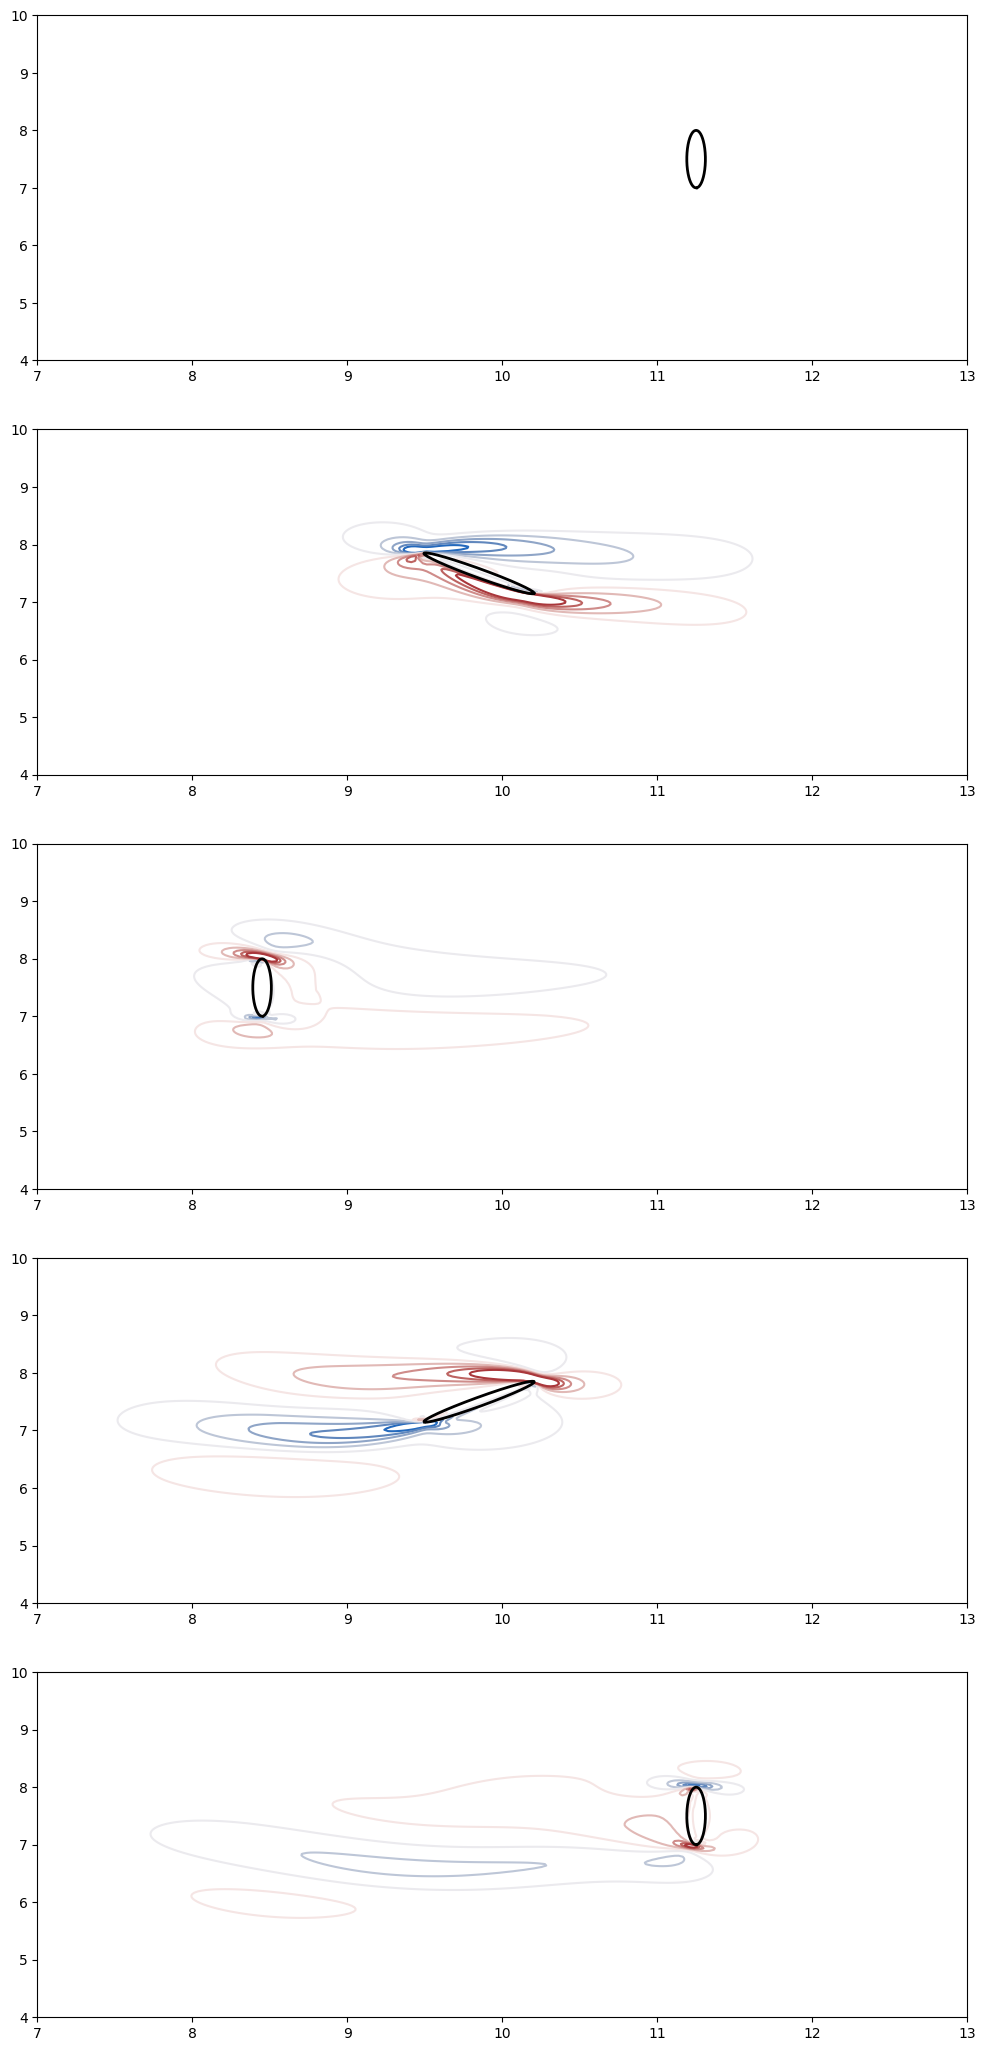

In [6]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps//2)

idx = 2
counter=0
for idx in range(0,outer_steps,2):

    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))

    particles_list = trajectory.particles
    geometry_param=particles_list.geometry_param[idx][0]
    xp0,yp0 = foil_XY_ELLIPSE(geometry_param,0)
    current_t = trajectory.velocity[0].bc.time_stamp[idx]
    particle_center = particles_list.particle_center[idx][0]

    theta_t = Rotation_EQ(rotation_param,current_t)
    xp = (xp0)*jnp.cos(theta_t)-(yp0)*jnp.sin(theta_t)+particle_center[0]
    yp = (xp0)*jnp.sin(theta_t)+(yp0 )*jnp.cos(theta_t)+particle_center[1]
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1
